#1. Import các thư viện cần thiết cho các bước tiền xử lý và trực quan hóa dữ liệu

In [20]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import math
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#2. Tiền xử lý dữ liệu

##2.1. Load dataset bài báo từ file CSV đã lưu


In [21]:
df = pd.read_csv("articles_dataset_raw.csv", index_col=0)
df

,Title,Description,Category,Platfrom,Area,URL
0,Cháy lớn quán bar ở Đồng Nai,"Lửa bùng lên ở quán bar, karaoke rộng hơn 300 ...",thoi-su,vnexpress,NaN,https://vnexpress.net/chay-lon-quan-bar-o-dong...
1,Dùng ngân sách Trung ương xây nhà mới cho ngườ...,Thủ tướng giao Bộ Tài chính đề xuất sử dụng ng...,thoi-su,vnexpress,NaN,https://vnexpress.net/dung-ngan-sach-trung-uon...
2,6 ôtô tông liên hoàn trên cao tốc Trung Lương,Sáu ôtô va chạm liên hoàn trên cao tốc TP HCM ...,thoi-su,vnexpress,Tây Ninh,https://vnexpress.net/6-oto-tong-lien-hoan-tre...
3,"Quân nhân Việt - Ấn diễn tập phá mìn, cứu hộ đ...","Trải qua ba tình huống thực binh, quân nhân Vi...",thoi-su,vnexpress,Hà Nội,https://vnexpress.net/quan-nhan-viet-an-dien-t...
4,Khởi công mở rộng cao tốc TP HCM - Trung Lương...,Tuyến cao tốc dài gần 100 km nối TP HCM với mi...,thoi-su,vnexpress,NaN,https://vnexpress.net/khoi-cong-mo-rong-cao-to...
...,...,...,...,...,...,...
15034,"Đang bay trên đỉnh núi, dù lượn của người đàn ...","Dù đã có kinh nghiệm chơi dù lượn lâu năm, son...",du-lich,vietnamnet,TRUNG QUỐC,https://vietnamnet.vn/dang-bay-tren-dinh-nui-d...
15035,Quán xôi 3 đời mẹ truyền con nối ở TPHCM đắt k...,Sau khi lọt vào danh sách Michelin Selected (n...,du-lich,vietnamnet,NaN,https://vietnamnet.vn/quan-xoi-3-doi-me-truyen...
15036,Bên trong ‘trận địa’ pháo hoa quốc tế Đà Nẵng ...,Trước thềm đêm khai mạc Lễ hội pháo hoa quốc t...,du-lich,vietnamnet,NaN,https://vietnamnet.vn/ben-trong-tran-dia-phao-...
15037,Lễ hội dâng đăng độc đáo mừng Lễ Vía Bà tại nú...,Từ ngày 30/5 - 1/6/2025 (nhằm ngày 4 - 6/5 âm ...,du-lich,vietnamnet,NaN,https://vietnamnet.vn/le-hoi-dang-dang-doc-dao...


##2.2. Tìm hiểu các dữ liệu bị missing:

In [22]:
df.isnull().sum()

,0
Title,1
Description,0
Category,0
Platfrom,0
Area,12928
URL,0


In [23]:
df[df['Title'].isnull()]

,Title,Description,Category,Platfrom,Area,URL
6858,NaN,"Chỉ sau một đêm, nước lũ càn quét qua xã Hòa T...",thoi-su,vietnamnet,NaN,/ron-lu-hoa-thinh-mot-thon-7-nguoi-chet-co-ca-...


Do cột area không quan trọng trong các quá trình sau nên ta không tiến hành điền các giá trị bị missing
Còn về cột title bị missing, ta có thể dropout dữ liệu này, hoặc có thể giữ lại vì thông tin description vẫn có giá trị cho việc dự đoán, ở đây chúng ta sẽ giữ nó lại


##2.3. Làm sạch dữ liệu trong cột Area


###2.3.1. Kiểm tra dữ liệu trong cột Area

In [24]:
df["Area"].unique()

array([nan, 'Tây Ninh', 'Hà Nội', 'Đồng Nai', 'Lạng Sơn', 'Hà Tĩnh',
       'Khánh Hòa', 'Lâm Đồng', 'Đà Nẵng', 'TP HCM', 'Đăk Lăk',
       'Hải Phòng', 'Quảng Trị', 'Gia Lai', 'Quảng Ninh', 'Nghệ An',
       'TP Huế', 'Cà Mau', 'Quảng Ngãi', 'An Giang', 'Lào Cai',
       'Thanh Hóa', 'Đồng Tháp', 'Ninh Bình', 'Tuyên Quang', 'Cần Thơ',
       'Trung Quốc', 'Italy', 'Mỹ', 'Campuchia', 'Yemen', 'Hàn Quốc',
       'Australia', 'Canada', 'Thổ Nhĩ Kỳ', 'Pháp', 'Philippines',
       'Ấn Độ', 'Đức', 'Hưng Yên', 'Bỉ', 'Anh', 'Ai Cập', 'Phần Lan',
       'Thái Nguyên', 'Thụy Sĩ', 'Malaysia', 'Nhật Bản', 'Phú Thọ',
       'New Zealand', 'London', 'Nga', 'Indonesia', 'Ecuador',
       'Tây Ban Nha', 'Paris', 'Bắc Ninh', 'Bangkok', 'Thái Lan',
       'Hy Lạp', 'Brazil', 'Cyprus', 'Bồ Đào Nha', 'Hà Lan', 'Arab Saudi',
       'Uruguay', 'Qatar', 'Hungary', 'Maldives', 'Lào', 'Morocco',
       'Scotland', 'Hong Kong', 'Sri Lanka', 'Na Uy', 'Albania',
       'Georgia', 'Macau', 'Azerbaijan', 'Singapor

###2.3.2. Chuẩn hóa về dạng chuẩn

In [25]:
# Chuyển các khu vực viết hoa về dạng thường rồi viết hoa chữ cái đầu
df["Area"] = df["Area"].astype(str).str.strip().str.title()

##2.4. Xóa các dữ liệu bị trùng lặp


###2.4.1. Kiểm tra các bài báo bị trùng lặp

In [26]:
dups = df[df["Title"].duplicated(keep=False)].sort_values("Title")
print(dups[["Title"]])

                                                   Title
8562   'Chim sắt' Wildcat bay 311 km/h, tên lửa Sea V...
8565   'Chim sắt' Wildcat bay 311 km/h, tên lửa Sea V...
2782   'Cần đánh thuế cao người thường xuyên mua bán ...
3257   'Cần đánh thuế cao người thường xuyên mua bán ...
1386   'GDP phải tăng ít nhất 5 lần trong 20 năm tới ...
...                                                  ...
13084     ‘Hạ Long Concert 2025’ bừng sáng bên bờ di sản
12456  ‘Người máy’ Haaland lập kỷ lục chưa từng có tạ...
12471  ‘Người máy’ Haaland lập kỷ lục chưa từng có tạ...
10223  ‘Sống thông minh’ cùng hệ thống điện mặt trời ...
10213  ‘Sống thông minh’ cùng hệ thống điện mặt trời ...

[909 rows x 1 columns]


###2.4.2. Xóa các bài báo trùng lặp để cải thiện chất lượng tập dữ liệu

In [27]:
df = df.drop_duplicates(subset=["Title"]).reset_index(drop=True)

##2.5. Lưu dữ liệu sau khi làm sạch vào file csv

In [28]:
df.to_csv('articles_dataset_clean.csv', index=True, encoding='utf-8-sig')

#3. Trực quan hóa dữ liệu

##3.1. Phân tích phân phối số từ trong tiêu đề và mô tả bài báo


###3.1.1. Mục tiêu


Mục tiêu của phân tích này là hiểu rõ **độ dài văn bản** trong tiêu đề và phần mô tả bài báo.
Việc này giúp ta:

- Đánh giá mức độ ngắn/dài của văn bản đầu vào
- Quyết định các bước tiền xử lý tiếp theo (cắt bớt văn bản,...)
- Lựa chọn phương pháp biểu diễn đặc trưng văn bản phù hợp (TF-IDF, n-gram)

###3.1.2. Phương pháp thực hiện

Ta tính **số từ** trong tiêu đề và phần mô tả của mỗi bài báo bằng cách tách văn bản theo khoảng trắng.
Sau đó, sử dụng thư viện `matplotlib` để vẽ **biểu đồ histogram** nhằm biểu diễn phân phối số từ.

Biểu đồ được chia thành **30 bins**, giúp quan sát rõ ràng tần suất xuất hiện của các độ dài văn bản khác nhau.

In [29]:
df["title_word_count"] = df["Title"].str.split().str.len()
df["desc_word_count"] = df["Description"].str.split().str.len()

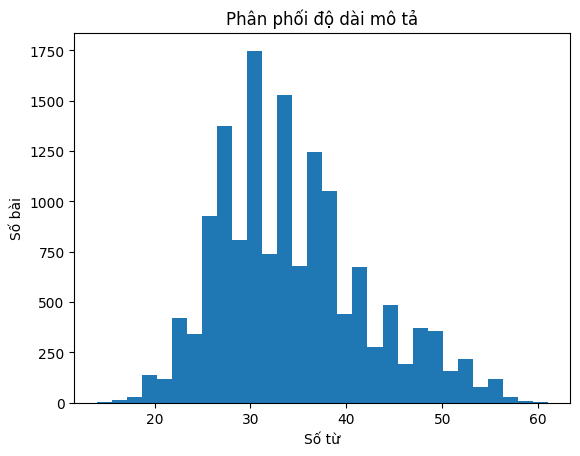

In [30]:
plt.hist(df["desc_word_count"], bins=30)
plt.title("Phân phối độ dài mô tả")
plt.xlabel("Số từ")
plt.ylabel("Số bài")
plt.show()

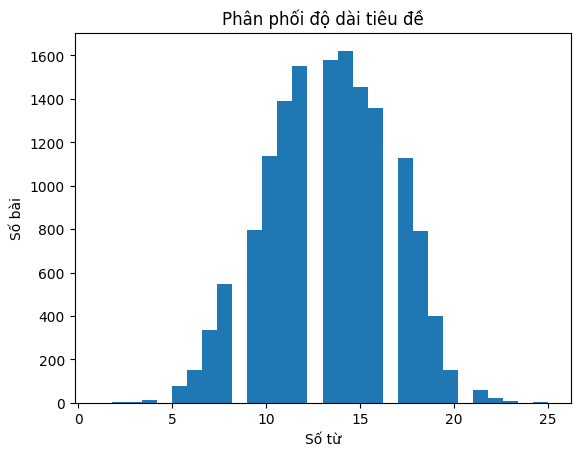

In [31]:
plt.hist(df["title_word_count"], bins=30)
plt.title("Phân phối độ dài tiêu đề")
plt.xlabel("Số từ")
plt.ylabel("Số bài")
plt.show()

##3.2. Tạo stopwords tiếng việt để chuẩn bị cho các bước kế tiếp:

Các từ được liệt kê thường không mang nhiều ý nghĩa trong tiếng việt và chúng ta cần loại bỏ chúng trong các bước trực quan hóa

In [32]:
vietnamese_stopwords_50 = {
    "là", "và", "của", "có", "cho", "với",
    "một", "những", "các", "được",
    "đã", "đang", "sẽ",
    "từ", "như", "khi", "này", "kia",
    "đó", "nên", "thì",
    "trên", "dưới", "vào", "ra",
    "rằng", "vì", "do", "nếu",
    "ở", "đến", "tại",
    "để", "cũng",
    "không", "chưa", "rất",
    "nhiều", "ít",
    "ai", "gì", "đâu",
    "đây", "kia", "ấy",
    "ta", "tôi", "bạn", "họ", "trong", "bị"
    "anh", "chị",
    "nó", "vậy", "Việt Nam"
}

##3.3. Tạo WordCloud cho từng Category

###3.3.1. Mục tiêu

Mục tiêu của bước trực quan hóa này là **khám phá đặc trưng từ vựng** của từng danh mục bài báo.
Thông qua WordCloud, chúng tôi có thể:

- Nhanh chóng nhận diện các **từ khóa xuất hiện thường xuyên** trong mỗi chủ đề
- So sánh sự khác biệt về nội dung giữa các danh mục
- Kiểm tra mức độ hợp lý của nhãn (Category) được gán cho bài báo
- Hỗ trợ việc lựa chọn đặc trưng cho bài toán phân loại chủ đề và gợi ý bài báo

###3.3.2. Phương pháp thực hiện

Ta tiến hành **nhóm dữ liệu theo từng danh mục (Category)**.
Với mỗi danh mục, toàn bộ phần mô tả (Description) của các bài báo được **tổng hợp thành một văn bản duy nhất**.

Trước khi tạo WordCloud, văn bản được xử lý bằng cách:
- Chuyển về chữ thường
- Loại bỏ các từ dừng (stopwords) tiếng Việt nhằm giảm nhiễu và làm nổi bật các từ mang ý nghĩa nội dung

Sau đó, ta sử dụng thư viện `WordCloud` để tạo biểu đồ từ khóa cho từng danh mục.
Các WordCloud được sắp xếp theo dạng **lưới (grid)** để thuận tiện cho việc quan sát và so sánh giữa các chủ đề.

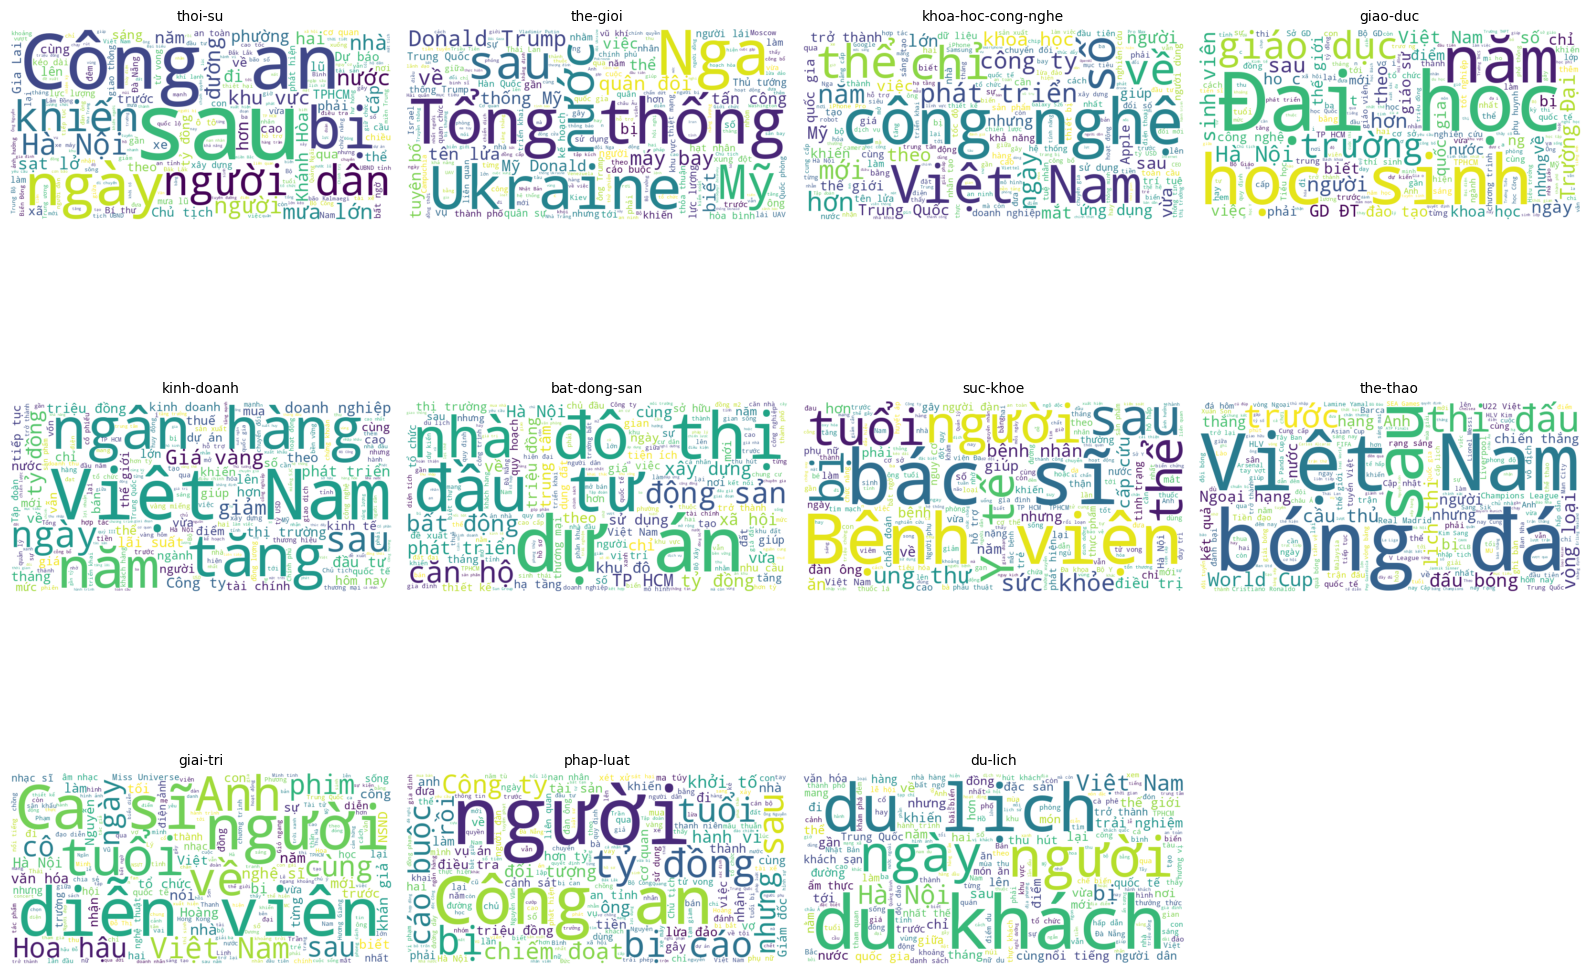

In [33]:
categories = df['Category'].unique()
n = len(categories)

# Tính số cột tối đa (ví dụ 4-5 cột mỗi hàng để vừa nhìn)
max_cols = 4
cols = min(n, max_cols)
rows = math.ceil(n / cols)

# Tạo figure
plt.figure(figsize=(cols*4, rows*4))  # mỗi subplot ~4x4 inch

for i, cat in enumerate(categories, 1):
    text = " ".join(df[df.Category == cat].Description.fillna(""))
    wc = WordCloud(width=800,
                   height=400,
                   background_color="white",
                   stopwords=vietnamese_stopwords_50
).generate(text)

    plt.subplot(rows, cols, i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(cat, fontsize=10)

plt.tight_layout()
plt.show()

##3.4. Phân phối các danh mục trong dữ liệu

Trong bước này, ta phân tích **phân phối số lượng bài báo theo từng danh mục (Category)** nhằm
đánh giá mức độ cân bằng của dữ liệu. Việc này giúp phát hiện các danh mục có quá ít hoặc quá nhiều
mẫu, từ đó ảnh hưởng trực tiếp đến hiệu quả và độ công bằng của mô hình phân loại.

Cụ thể, ta thống kê số lượng bài báo thuộc mỗi danh mục và sử dụng biểu đồ cột để trực quan hóa
phân phối dữ liệu. Biểu đồ cho phép quan sát nhanh sự chênh lệch về quy mô giữa các chuyên mục.


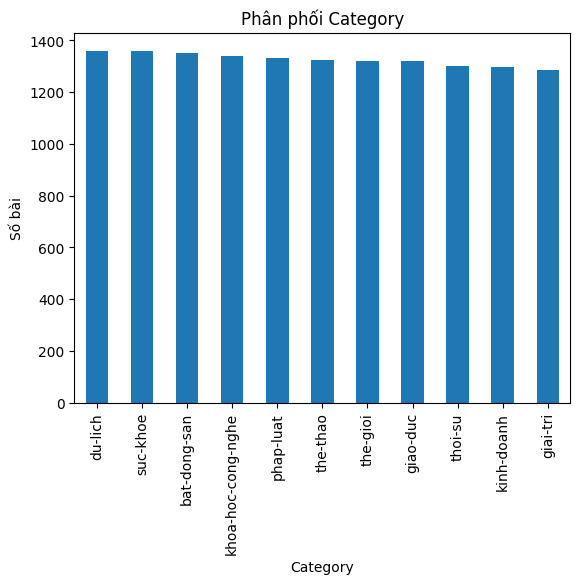

In [34]:
df["Category"].value_counts().plot(kind="bar")
plt.title("Phân phối Category")
plt.ylabel("Số bài")
plt.show()

##3.5. Phân tích và trực quan hóa Top 10 địa danh xuất hiện nhiều nhất

Tại phần này, ta phân tích **tần suất xuất hiện của các địa danh (Area)** trong tập dữ liệu
nhằm xác định những khu vực được đề cập nhiều nhất trong các bài báo.
Phân tích này giúp nhận diện các địa điểm nổi bật, phản ánh mức độ quan tâm của truyền thông
đối với từng khu vực, đồng thời cung cấp ngữ cảnh bổ sung cho việc phân loại chủ đề và gợi ý bài báo.

Trước tiên, ta loại bỏ các giá trị không hợp lệ hoặc bị thiếu trong cột `Area`.
Sau đó, dữ liệu được thống kê theo tần suất xuất hiện của từng địa danh, sắp xếp theo thứ tự giảm dần
và lựa chọn **10 địa danh có số lượng bài viết nhiều nhất**.
Kết quả được trực quan hóa bằng **biểu đồ cột ngang**, giúp việc so sánh giữa các khu vực trở nên trực quan hơn.


/tmp/ipython-input-2681508808.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette='viridis')


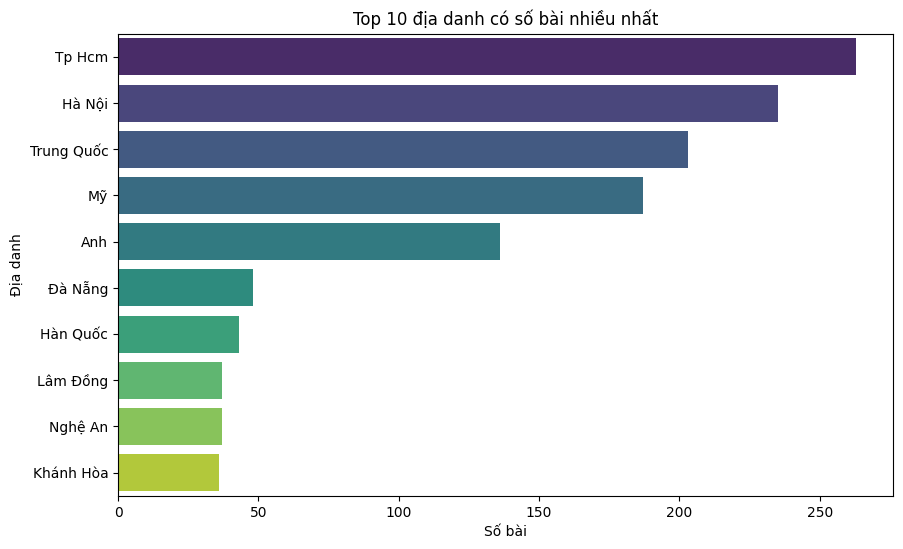

In [35]:
# Bỏ các giá trị None
df_filtered = df[df['Area'] != 'Nan']

# Đếm số lần xuất hiện từng địa danh
counts = df_filtered['Area'].value_counts()

# Lấy top 10
top10 = counts.head(10)

# Vẽ barplot
plt.figure(figsize=(10,6))
sns.barplot(x=top10.values, y=top10.index, palette='viridis')
plt.xlabel("Số bài")
plt.ylabel("Địa danh")
plt.title("Top 10 địa danh có số bài nhiều nhất")
plt.show()

##3.6. Trích xuất và trực quan hóa các từ khóa xuất hiện nhiều nhất bằng CountVectorizer

###3.6.1. Mục tiêu

Mục tiêu của bước này là **phân tích nội dung văn bản theo hướng định lượng**
thông qua việc xác định các từ khóa xuất hiện với tần suất cao trong tập dữ liệu.

Việc trích xuất các từ khóa phổ biến giúp:
- Hiểu rõ hơn về các chủ đề và khái niệm được đề cập nhiều nhất
- Làm cơ sở cho việc lựa chọn phương pháp trích xuất đặc trưng văn bản
trong bài toán phân loại chủ đề và gợi ý bài báo

###3.6.2. Phương pháp thực hiện

Ta kết hợp nội dung từ **Title** và **Description** của mỗi bài báo
để tạo thành một corpus văn bản hoàn chỉnh.
Văn bản được tiền xử lý bằng cách loại bỏ stopwords tiếng Việt nhằm giảm nhiễu.

Sau đó, ta sử dụng **CountVectorizer** trong thư viện `scikit-learn`
để chuyển corpus văn bản thành **ma trận tần suất từ** theo mô hình Bag-of-Words.
Tùy chọn sử dụng unigram hoặc n-gram giúp phân tích không chỉ các từ đơn lẻ
mà còn các cụm từ có ý nghĩa.

Tổng tần suất xuất hiện của mỗi từ (hoặc n-gram) được tính toán,
từ đó lựa chọn các từ khóa có tần suất cao nhất và trực quan hóa bằng
**biểu đồ cột ngang** để thuận tiện cho việc so sánh.

In [36]:
def draw_graph_top_keyword(size = (2,2)):
    text_corpus = df['Description'].fillna("") + " " + df['Title'].fillna("")

    # Tạo CountVectorizer
    vectorizer = CountVectorizer(stop_words=list(vietnamese_stopwords_50), ngram_range=size)
    X = vectorizer.fit_transform(text_corpus)

    # Tính tần suất từ
    sum_words = X.sum(axis=0)
    words_freq = [(word, int(sum_words[0, idx])) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Lấy top 30 keyword
    top_kw = words_freq[:30]
    words = [w for w, c in top_kw]
    counts = [c for w, c in top_kw]

    # Vẽ biểu đồ
    plt.figure(figsize=(8,5))
    plt.barh(words[::-1], counts[::-1])
    plt.title(f"Top Keywords {size[0]}")
    plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['nam', 'việt'] not in stop_words.
  warnings.warn(


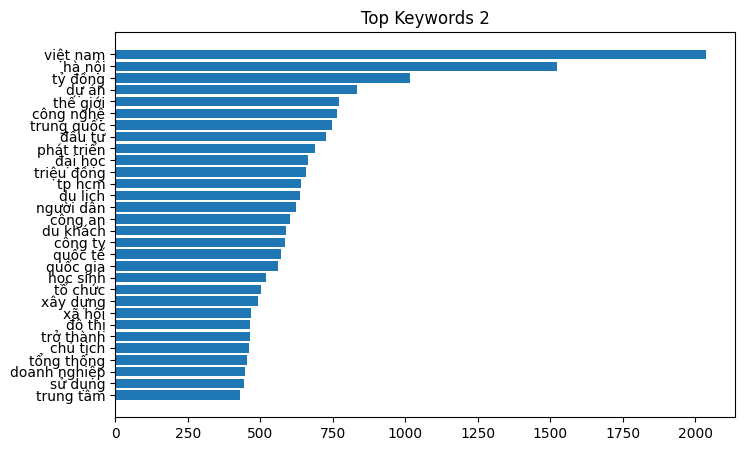

In [37]:
draw_graph_top_keyword((2,2))

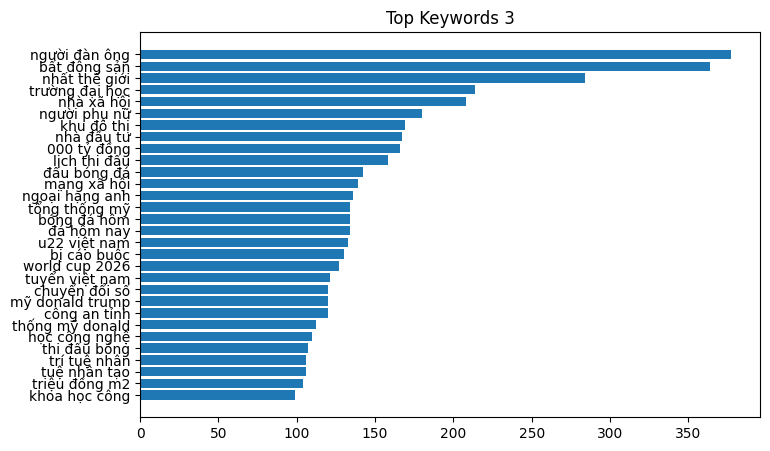

In [38]:
draw_graph_top_keyword((3,3))

##3.7. Phân tích từ khóa nổi bật từng Category với TF-IDF

###3.7.1. Mục tiêu

Mục tiêu của bước phân tích này là **xác định các từ khóa mang tính đặc trưng cao**
cho từng danh mục bài báo dựa trên trọng số TF-IDF.

Khác với phương pháp đếm tần suất đơn thuần, TF-IDF giúp làm nổi bật
những từ xuất hiện thường xuyên trong một danh mục
nhưng ít xuất hiện ở các danh mục khác.
Điều này cho phép:
- Nhận diện đặc trưng nội dung riêng biệt của từng chủ đề
- Đánh giá mức độ phân biệt giữa các danh mục
- Hỗ trợ trực tiếp cho bài toán phân loại chủ đề và hệ thống gợi ý bài báo

###3.7.2. Phương pháp thực hiện

Ta tiến hành **nhóm dữ liệu theo từng danh mục (Category)**.
Với mỗi danh mục, toàn bộ nội dung từ **Title** và **Description**
được tổng hợp thành một corpus đại diện.

Sau đó, ta sử dụng **TfidfVectorizer** trong thư viện `scikit-learn`
để mã hóa văn bản thành ma trận TF-IDF.
Quá trình này bao gồm:
- Loại bỏ stopwords tiếng Việt nhằm giảm nhiễu
- Sử dụng **bigram (n-gram = 2)** để trích xuất các cụm từ có ý nghĩa ngữ cảnh

Đối với mỗi danh mục, điểm TF-IDF của các từ được tổng hợp,
từ đó lựa chọn các từ khóa có trọng số cao nhất
và trực quan hóa bằng **biểu đồ cột ngang**.
Các biểu đồ được sắp xếp theo dạng **lưới** để thuận tiện cho việc so sánh.


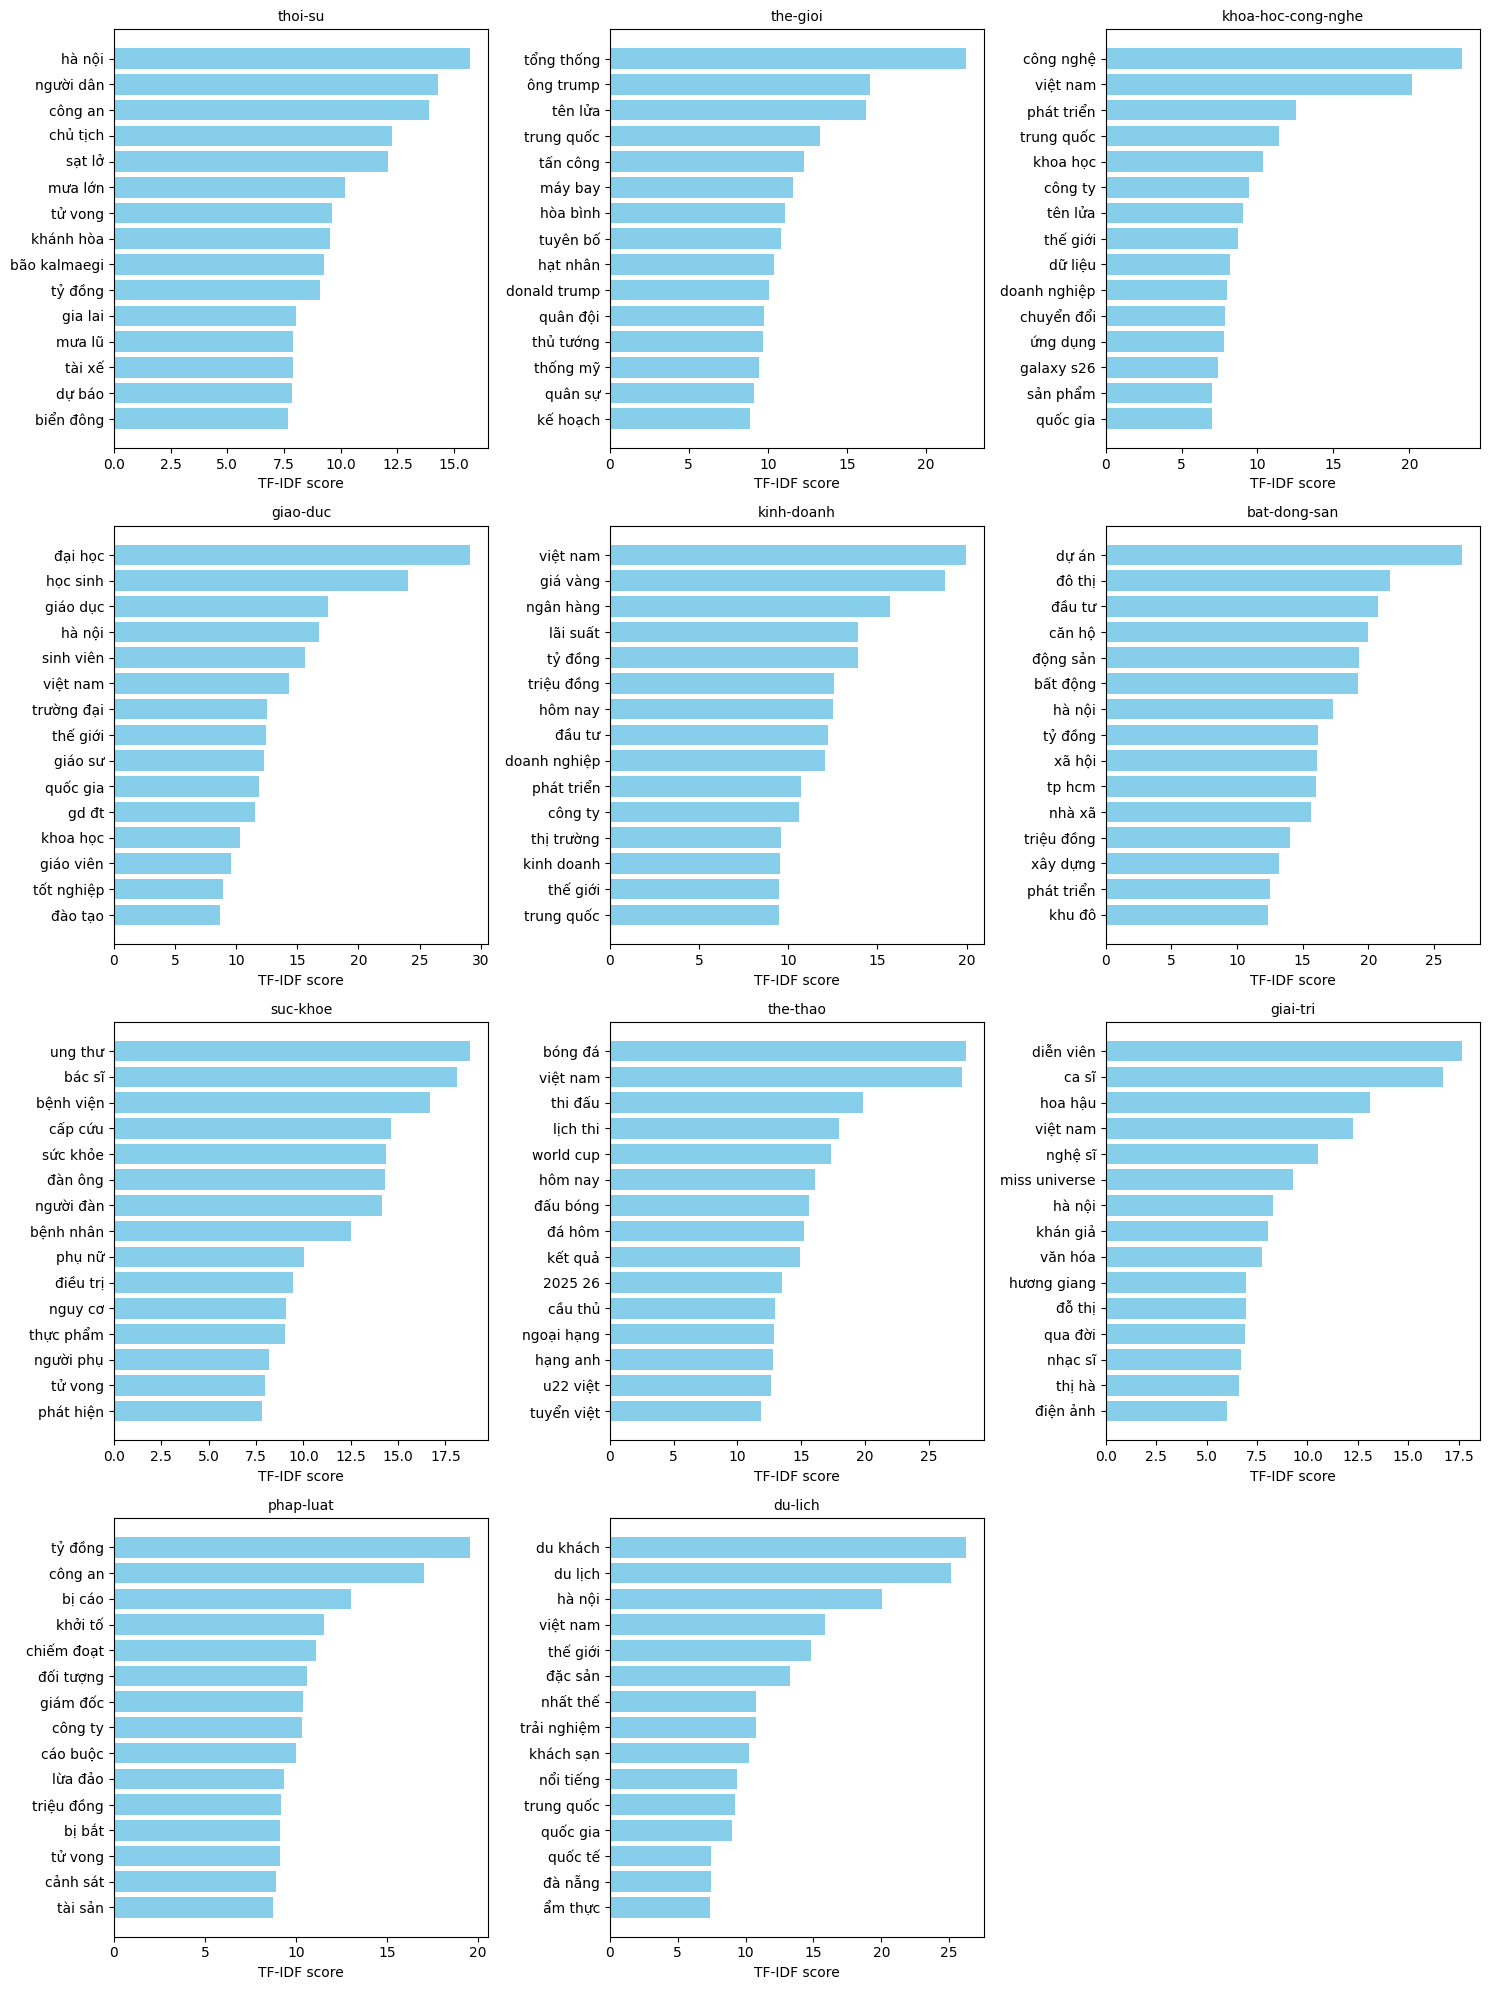

In [39]:
categories = df['Category'].unique()
n = len(categories)

max_cols = 3
cols = min(n, max_cols)
rows = math.ceil(n / cols)
plt.figure(figsize=(cols*5, rows*5))

for i, cat in enumerate(categories, 1):
    # Lấy text của category này
    text_corpus = df[df['Category'] == cat]['Description'].fillna("") + " " + df[df['Category'] == cat]['Title'].fillna("")

    # Tạo TF-IDF
    vectorizer = TfidfVectorizer(stop_words=list(vietnamese_stopwords_50), ngram_range=(2,2))
    X = vectorizer.fit_transform(text_corpus)

    # Tính tổng TF-IDF mỗi từ trong category
    sums = X.sum(axis=0)
    words_freq = [(word, float(sums[0, idx])) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Lấy top 15 từ
    top_words = words_freq[:15]
    words = [w for w, s in top_words]
    scores = [s for w, s in top_words]

    # Vẽ bar chart
    plt.subplot(rows, cols, i)
    plt.barh(words[::-1], scores[::-1], color='skyblue')
    plt.title(cat, fontsize=10)
    plt.xlabel("TF-IDF score")
    plt.tight_layout()

plt.show()